<a href="https://colab.research.google.com/github/AfifNurraihan/Kumpulan-Proyek-Python/blob/main/Image_Classification_Model_Deployment_(Afif_Nurraihan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q Kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 343M/346M [00:03<00:00, 68.6MB/s]
100% 346M/346M [00:04<00:00, 89.5MB/s]


In [5]:
# Extract the zip file
import zipfile,os
local_zip = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
# View folder name in zip file
viw_dir = '/content/seg_train'
print("Names of the folders inside the zip file : ", os.listdir(viw_dir))

Names of the folders inside the zip file :  ['seg_train']


In [17]:
# Defining the rock, paper, and scissors image training folder 
data = os.path.join('/content/seg_train/seg_train')
basis_dir = data

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [19]:
# Grouping data into Training Data and Validation Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=30,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

In [20]:
# Data labeling using ImageDataGenerator by folder
train_generator = train_datagen.flow_from_directory(
        basis_dir,               
        target_size=(150, 150),  # change the resolution of the whole image to 150x150 pixels
        # as this is a class 6 classification problem then use class_mode = 'categorical'
        class_mode='categorical',
        shuffle=True,
        subset='training')

validation_generator= train_datagen.flow_from_directory(
        basis_dir,
        target_size=(150, 150), # change the resolution of the whole image to 150x150 pixels 
        # as this is a class 6 classification problem then use class_mode = 'categorical'
        class_mode='categorical',
        shuffle=True,
        subset='validation')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [23]:
# Using Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>=0.86):
      print("\nStop Training because accuracy has reached 95%")
      self.model.stop_training= True
callbacks = myCallback()

In [24]:
# Building an artificial neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [25]:
num_epochs = 50 
#optimizer = tf.optimizers.Adam()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
history = model.fit(train_generator,epochs=num_epochs,validation_data=validation_generator,callbacks=[callbacks])

Epoch 1/50
351/351 [==============================] - 81s 231ms/step - loss: 1.3235 - accuracy: 0.4666 - val_loss: 1.0279 - val_accuracy: 0.6070
Epoch 2/50
351/351 [==============================] - 79s 225ms/step - loss: 0.9656 - accuracy: 0.6337 - val_loss: 0.9056 - val_accuracy: 0.6626
Epoch 3/50
351/351 [==============================] - 80s 227ms/step - loss: 0.8727 - accuracy: 0.6701 - val_loss: 0.8988 - val_accuracy: 0.6512
Epoch 4/50
351/351 [==============================] - 79s 225ms/step - loss: 0.8251 - accuracy: 0.6952 - val_loss: 0.8016 - val_accuracy: 0.7161
Epoch 5/50
351/351 [==============================] - 79s 225ms/step - loss: 0.7939 - accuracy: 0.7051 - val_loss: 0.7745 - val_accuracy: 0.7136
Epoch 6/50
351/351 [==============================] - 80s 227ms/step - loss: 0.7589 - accuracy: 0.7190 - val_loss: 0.7395 - val_accuracy: 0.7361
Epoch 7/50
351/351 [==============================] - 79s 225ms/step - loss: 0.7329 - accuracy: 0.7272 - val_loss: 0.6862 - val_ac

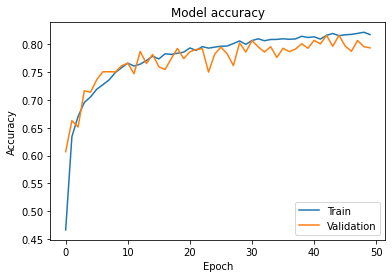

In [30]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

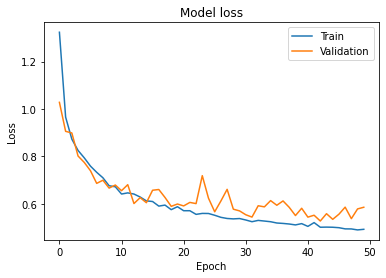

In [33]:
# Plot Loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [32]:
# Saving models into SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel to vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

22517712